In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Mount Drive
!unzip /content/drive/MyDrive/TransferLearnImages.zip

data_root = "/content/TransferLearnImages/"

In [3]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 188 files belonging to 2 classes.
Using 151 files for training.


In [4]:
class_names = np.array(train_ds.class_names)

['Football' 'Racket']


In [5]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [9]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

In [10]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [26]:
history = model.fit(train_ds, epochs=5)

Epoch 1/5
5/5 [==============================] - 0s 35ms/step - loss: 0.0030 - acc: 1.0000
Epoch 2/5
5/5 [==============================] - 0s 29ms/step - loss: 0.0028 - acc: 1.0000
Epoch 3/5
5/5 [==============================] - 0s 26ms/step - loss: 0.0026 - acc: 1.0000
Epoch 4/5
5/5 [==============================] - 0s 26ms/step - loss: 0.0024 - acc: 1.0000
Epoch 5/5
5/5 [==============================] - 0s 26ms/step - loss: 0.0023 - acc: 1.0000


--2020-12-11 23:44:59--  https://image.shutterstock.com/image-photo/soccer-ball-isolated-on-white-260nw-400438939.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 23.200.169.105
Connecting to image.shutterstock.com (image.shutterstock.com)|23.200.169.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9309 (9.1K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   9.09K  --.-KB/s    in 0s      

2020-12-11 23:44:59 (229 MB/s) - ‘image.jpg’ saved [9309/9309]

['Football']


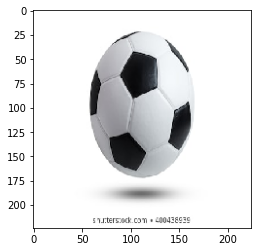

In [18]:
# test model with new image
!wget -O image.jpg https://image.shutterstock.com/image-photo/soccer-ball-isolated-on-white-260nw-400438939.jpg
#!wget -O image.jpg https://www.tennisnuts.com/images/product/full/102334-136_babolat-pure-drive_angle.jpg

# process image for model
img = image.load_img('image.jpg', target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# display image
import matplotlib.pyplot as plt
plt.imshow(img)

# run prediction
prediction = model.predict(x)
predicted_id = np.argmax(prediction, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)